In [1]:
# importing requirements
!pip install wget
import wget
import torch
import gc
torch.manual_seed(0) #For reproducibility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#download the dataset
url='https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/rscbjbr9sj-2.zip'

wget.download(url, '/content/Data.zip')

'/content/Data (1).zip'

In [3]:
#unzipping the files
!unzip /content/Data.zip -d /content/
!gzip -d /content/OCT2017.tar.gz
!tar -xf /content/OCT2017.tar -C /content

Archive:  /content/Data.zip
  inflating: /content/OCT2017.tar.gz  
replace /content/ChestXRay2017.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/ChestXRay2017.zip  
replace /content/code2017.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/code2017.zip   
gzip: /content/OCT2017.tar already exists; do you wish to overwrite (y or n)? y


In [4]:
from MyDataSet import OCTDataset

train_set = OCTDataset('/content/OCT2017/train')

for x, y in train_set:
  print(x.shape)
  break
gc.collect()
# CNV 37205
# DME 11348
# DRUSEN 8616
# NORMAL 26315

valid_set = OCTDataset('/content/OCT2017/test')

for x, y in valid_set:
  print(x.shape)
  break

# CNV 250
# DME 250
# DRUSEN 250
# NORMAL 250
gc.collect()

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


0

In [5]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
from MyResNet import ResidualBlock, ResNet, BottleneckBlock, ResNet50

# For ResNet18:
model = ResNet(ResidualBlock,[2,2,2,2],4).to(device)
# For ResNet34:
# model = ResNet(ResidualBlock,[3,4,6,3],4).to(device)
# For ResNet50:
# model = ResNet50(BottleneckBlock,[3,4,6,3],4).to(device) 

In [7]:
num_iter = 10
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_iter, eta_min=5e-6)
scaler = torch.cuda.amp.GradScaler()

In [8]:
from TrainnTest import train, test
best_accuracy = 0.0
train_acc_list, test_acc_list = [], []
train_loss_list, test_loss_list = [], []

gc.collect()
for epoch in range(num_iter):
    print("\nEpoch: {}/{}".format(epoch+1, num_iter))

    train_loss, train_acc = train(trainloader,model, loss_fn, optimizer, scaler,device)

    test_loss, test_acc = test(testloader,model, loss_fn,device)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Accuracy {:.04f}\nValid Loss {:.04f}\t Valid Accuracy {:.04f}\nLearning Rate {:.08f}".format(
        epoch + 1,
        num_iter,
        train_loss,
        train_acc,
        test_loss,
        test_acc,
        float(optimizer.param_groups[0]['lr']))
    )
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
    scheduler.step()

    if test_acc > best_accuracy:
      best_accuracy = test_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'test_acc': test_acc, 
                  'epoch': epoch}, './mresnet_best.pth')


Epoch: 1/10



Epoch 1/10: 
Train Loss 0.2953	 Train Accuracy 0.8961
Valid Loss 0.0374	 Valid Accuracy 0.9936
Learning Rate 0.00010000

Epoch: 2/10



Epoch 2/10: 
Train Loss 0.1678	 Train Accuracy 0.9423
Valid Loss 0.0520	 Valid Accuracy 0.9867
Learning Rate 0.00009768

Epoch: 3/10



Epoch 3/10: 
Train Loss 0.1352	 Train Accuracy 0.9537
Valid Loss 0.0341	 Valid Accuracy 0.9951
Learning Rate 0.00009093

Epoch: 4/10



Epoch 4/10: 
Train Loss 0.1092	 Train Accuracy 0.9622
Valid Loss 0.0716	 Valid Accuracy 0.9842
Learning Rate 0.00008042

Epoch: 5/10



Epoch 5/10: 
Train Loss 0.0839	 Train Accuracy 0.9709
Valid Loss 0.0140	 Valid Accuracy 0.9971
Learning Rate 0.00006718

Epoch: 6/10



Epoch 6/10: 
Train Loss 0.0579	 Train Accuracy 0.9803
Valid Loss 0.0263	 Valid Accuracy 0.9932
Learning Rate 0.00005250

Epoch: 7/10



Epoch 7/10: 
Train Loss 0.0383	 Train Accuracy 0.9874
Valid Loss 0.0085	 Valid Accuracy 0.9980
Learning Rate 0.00003782

Epoch: 8/10



Epoch 8/10: 
Train Loss 0.0238	 Train Accuracy 0.9921
Valid Loss 0.0040	 Valid Accuracy 0.9990
Learning Rate 0.00002458

Epoch: 9/10



Epoch 9/10: 
Train Loss 0.0171	 Train Accuracy 0.9943
Valid Loss 0.0116	 Valid Accuracy 0.9951
Learning Rate 0.00001407

Epoch: 10/10



Epoch 10/10: 
Train Loss 0.0125	 Train Accuracy 0.9951
Valid Loss 0.0109	 Valid Accuracy 0.9951
Learning Rate 0.00000732


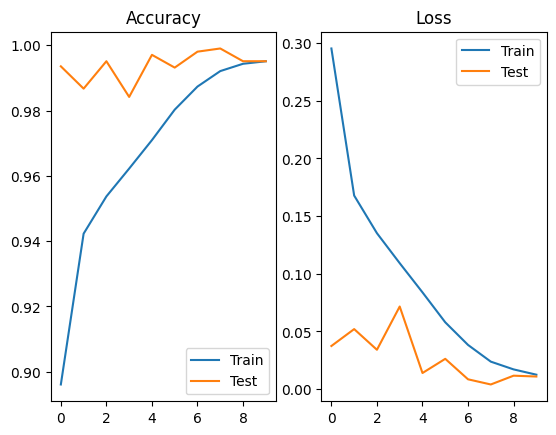

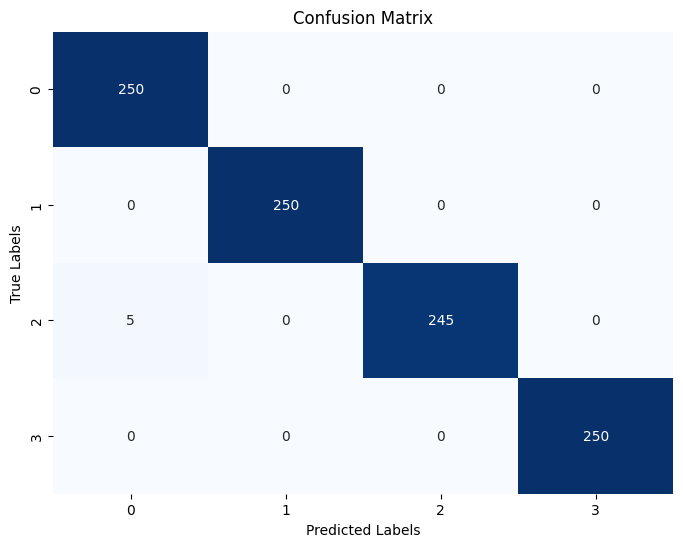

580
pred 0
truth 2


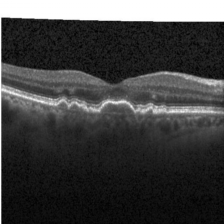

614
pred 0
truth 2


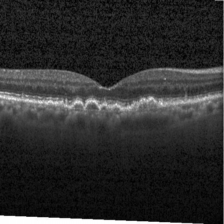

615
pred 0
truth 2


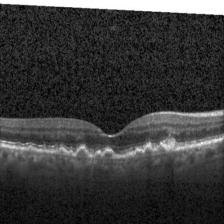

654
pred 0
truth 2


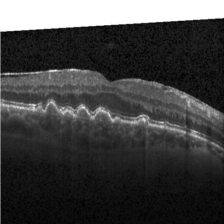

748
pred 0
truth 2


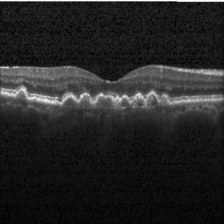

In [11]:
from ResultAnalysis import PlotEpoch, ShowMistakes,ShowConfusionMatrix,GetPredictions
PlotEpoch(test_acc_list,test_loss_list,train_acc_list,train_loss_list)
preds, labels = GetPredictions(model,testloader,device)
ShowConfusionMatrix(preds,labels)
ShowMistakes(preds,labels,valid_set)